In [1]:
from astropy.table import Table, vstack
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
pub_res_tab = Table.read("/home/nmearl/research/tde_agn_comparison/pub_results.txt", format='ascii')
pub_objs_tab = Table.read("/home/nmearl/research/tde_agn_comparison/pub_objs.txt", format='ascii')

In [3]:
pub_objs_tab.pprint()

    ZTF      RAh RAm  RAs   DE- DEd ... e_E1   E2   e_E2 RACS e_RACS f_RACS
              h  min   s        deg ... mJy   mJy   mJy  mJy   mJy         
------------ --- --- ------ --- --- ... ---- ------ ---- ---- ------ ------
ZTF18aaaotwe  13  13 10.376  --  15 ...   --     --   --   --     --     --
ZTF18aaaovpz  10  39  13.82  --   9 ...   --     --   --   --     --     --
ZTF18aaavwka  12  35 44.246  --  16 ...   --     --   --   --     --     --
ZTF18aabkubl  11  25 58.744  --  20 ... 3.08 404.21 0.84   --     --     --
ZTF18aabylvn  14  17 59.554  --  25 ... 0.29   3.45 0.29   --     --     --
ZTF18aacajqc  10  29 46.791  --  40 ...   --     --   --   --     --      d
ZTF18aacbjdm  12  32  3.637  --  20 ...   --     --   --  3.6   1.07     --
ZTF18aaccaxc  13  37 39.948  --  39 ... 0.27   3.09 0.63   --     --      d
ZTF18aacckko  14   5 44.376  --  40 ...   --     --   --   --     --      d
         ... ... ...    ... ... ... ...  ...    ...  ...  ...    ...    ...
ZTF19adcftma

In [4]:
pmap = {
'ZTF': 'label',
 'xi1': 'halpha_disk_inner_radius',
 'E_xi1': 'halpha_disk_inner_radius_up_err',
 'e_xi1': 'halpha_disk_inner_radius_lo_err',
 'xi2': 'halpha_disk_outer_radius',
 'E_xi2': 'halpha_disk_outer_radius_up_err',
 'e_xi2': 'halpha_disk_outer_radius_lo_err',
 'sigma': 'halpha_disk_sigma',
 'E_sigma': 'halpha_disk_sigma_up_err',
 'e_sigma': 'halpha_disk_sigma_lo_err',
 'i': 'halpha_disk_inclination',
 'E_i': 'halpha_disk_inclination_up_err',
 'e_i': 'halpha_disk_inclination_lo_err',
 'q': 'halpha_disk_q',
 'E_q': 'halpha_disk_q_up_err',
 'e_q': 'halpha_disk_q_lo_err',
 'phi': 'halpha_disk_apocenter',
 'E_phi': 'halpha_disk_apocenter_up_err',
 'e_phi': 'halpha_disk_apocenter_lo_err',
}

pub_res_tab.rename_columns(list(pmap.keys()), list(pmap.values()))
pub_res_tab['source'] = 'panic'
pub_res_tab['halpha_disk_inclination'] = np.deg2rad(pub_res_tab['halpha_disk_inclination'])
pub_res_tab['halpha_disk_apocenter'] = np.deg2rad(pub_res_tab['halpha_disk_apocenter'])
pub_res_tab = pub_res_tab[list(pmap.values()) + ['source']]
pub_res_tab = pub_res_tab[[x for x in pub_res_tab.colnames if 'err' not in x]]
pub_res_df = pub_res_tab.to_pandas()

In [5]:
results_dir = "/home/nmearl/research/tde_agn_comparison/results"

full_tab = None

for path in Path(results_dir).iterdir():
    label = path.stem

    if not (path / "disk_param_results.csv").exists():
        continue

    if full_tab is None:
        full_tab = Table.read(path / "disk_param_results.csv")
    else:
        tab = Table.read(path / "disk_param_results.csv")
        full_tab = vstack([full_tab, tab])

    # tab = Table.read(path / f"{label}" / "disk_param_results.csv")

full_tab['z'] = 0

for label in full_tab['label']:
    full_tab['z'][full_tab['label'] == label] = pub_objs_tab['z'][pub_objs_tab['ZTF'] == label]

df = full_tab.to_pandas()

In [6]:
pdf = df.pivot(index='label', columns='param', values='value')
pdf['r_hat'] = df.groupby('label')['r_hat'].mean().apply(lambda x: 0.99 <= x <= 1.01)
pdf['source'] = 'local'


z_vals = [np.mean(pub_objs_tab['z'][pub_objs_tab['ZTF'] == label]) for label in pdf.index]

pdf['z'] = z_vals

In [7]:
# pdf = pd.concat([pdf, pub_res_df], sort=False)

In [8]:
# pub_objs_tab['z'][pub_objs_tab['ZTF'] == label].pprint()
# pdf['z'][pdf.index == label]

In [9]:
pdf

param,halpha_disk_apocenter,halpha_disk_center,halpha_disk_delta_radius,halpha_disk_eccentricity,halpha_disk_inclination,halpha_disk_inner_radius,halpha_disk_offset,halpha_disk_outer_radius,halpha_disk_q,halpha_disk_scale,...,siil_narrow_amplitude,siil_narrow_center,siil_narrow_vel_width,siir_narrow_amplitude,siir_narrow_center,siir_narrow_vel_width,white_noise,r_hat,source,z
label,,,,,,,,,,,,,,,,,,,,,
ZTF18aaaotwe,2.306320,6565.260328,2793.953859,0.578624,0.187354,3236.852032,0.0,6151.146172,3.027271,0.212785,...,0.140418,6717.974448,473.929037,0.106622,6732.578256,473.929037,-6.730308,True,local,0.0657
ZTF18aaaovpz,2.243085,6565.330392,2135.926894,0.812300,0.263210,195.615618,0.0,2341.539811,3.529784,0.148559,...,0.001535,6716.680014,1119.191364,0.026686,6733.825927,1119.191364,-4.952607,True,local,0.2170
ZTF18aaavwka,0.186752,6564.126821,8212.343202,0.560447,0.424244,323.726222,0.0,8539.623560,0.574101,1.700768,...,0.202350,6718.077800,322.904550,0.181940,6732.407009,322.904550,-7.493111,True,local,0.0711
ZTF18aabkubl,3.563124,6563.396893,7415.920298,0.514965,0.258352,136.537032,0.0,7575.110101,0.963259,0.111894,...,0.267574,6715.292932,674.882463,0.258839,6731.596236,674.882463,-7.099281,True,local,0.1330
ZTF18aabylvn,4.665557,6566.891195,1151.180987,0.976701,0.738435,3624.191748,0.0,4967.152918,0.772770,13.034481,...,2.374751,6721.299723,572.223516,3.045977,6735.678064,572.223516,-2.083150,True,local,0.0163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aalyhuc,1.787622,6564.485218,8925.116834,0.642196,0.253263,122.584195,0.0,9045.630322,1.140984,0.159615,...,0.255222,6718.459580,378.296172,0.216741,6732.109586,378.296172,-2.896538,True,local,0.0712
ZTF20aamaqmq,2.574901,6566.913128,3291.390477,0.284765,0.626840,3360.244005,0.0,6695.775250,1.383545,0.222998,...,0.025170,6715.365502,504.008499,0.044056,6733.669215,504.008499,-7.043694,True,local,0.3220
ZTF20aaosbad,2.077326,6565.129943,2777.765889,0.626417,0.208017,3297.533183,0.0,6172.998938,3.075384,0.252321,...,0.027374,6716.427452,579.229823,0.021800,6731.441425,579.229823,-6.795333,True,local,0.3100


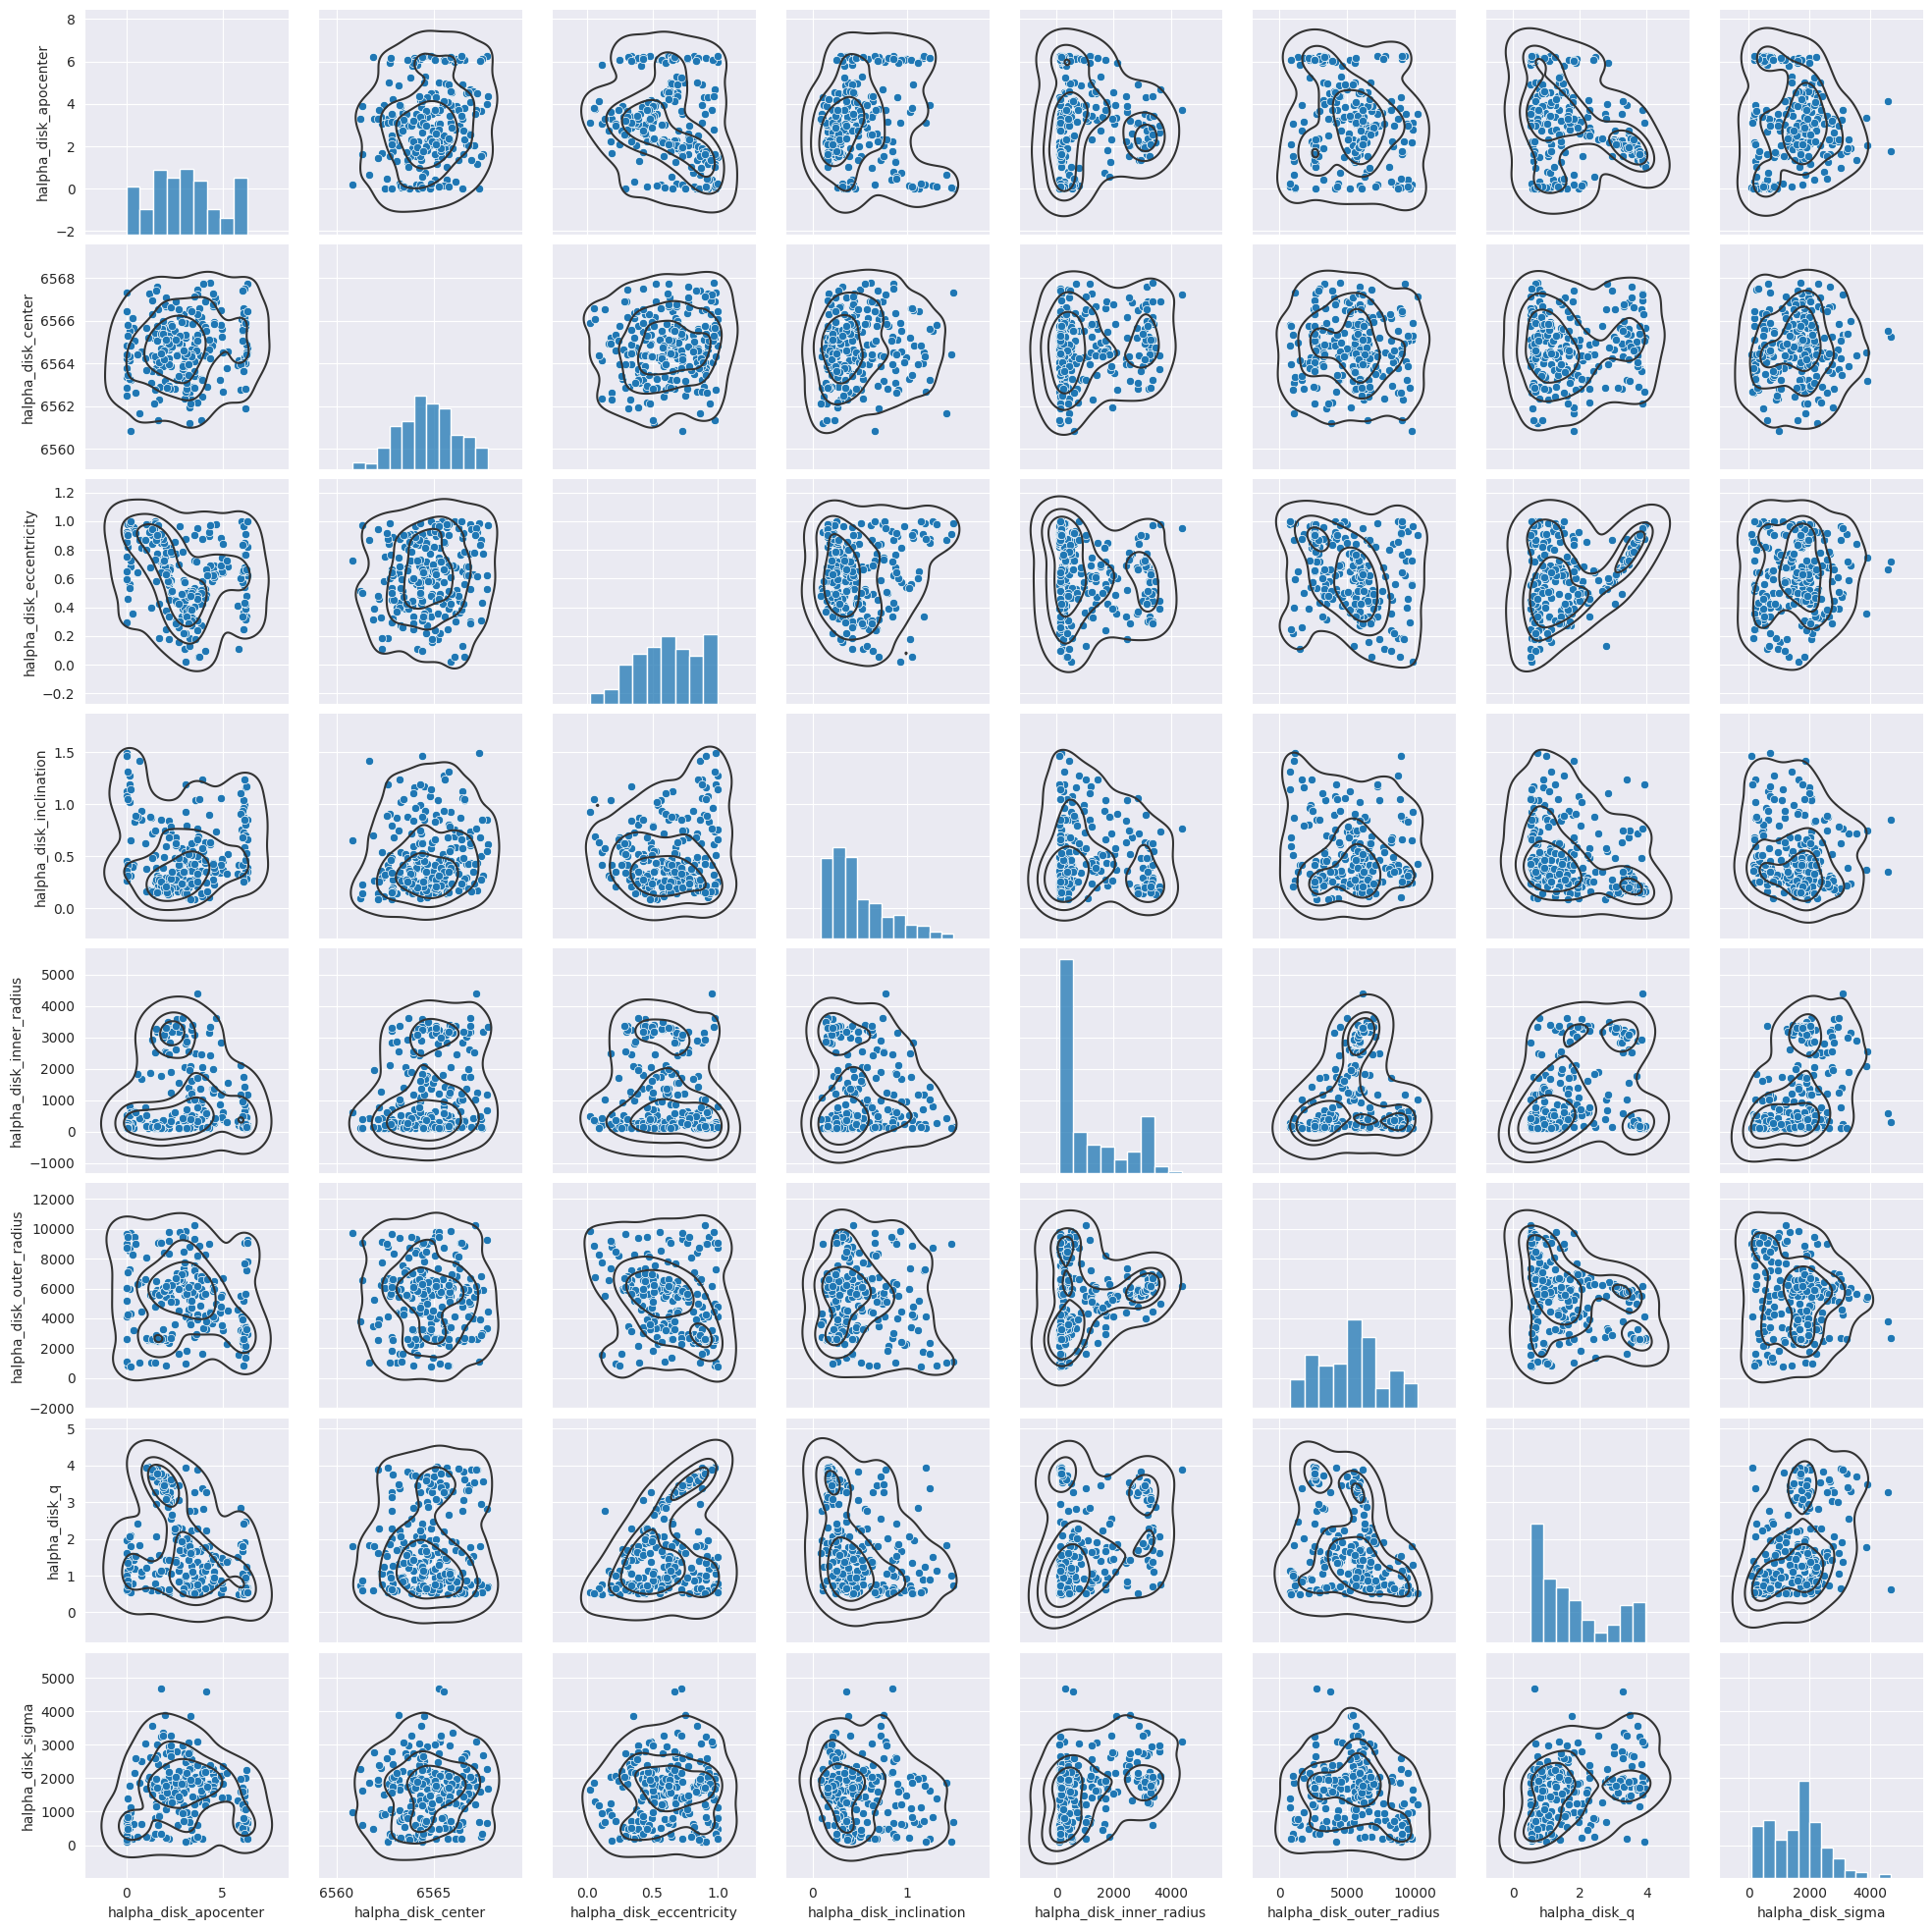

In [11]:
vars = list(set(df['param']))

g = sns.pairplot(
    pdf,
    x_vars=[x for x in pdf.columns if x.startswith("halpha_disk") and x not in [
        'halpha_disk_offset', 'halpha_disk_scale', 'halpha_disk_delta_radius', 
        # 'halpha_disk_center', 'halpha_disk_eccentricity'
    ] and not x.endswith("_flux")],
    y_vars=[x for x in pdf.columns if x.startswith("halpha_disk") and x not in [
        'halpha_disk_offset', 'halpha_disk_scale', 'halpha_disk_delta_radius', 
        # 'halpha_disk_center', 'halpha_disk_eccentricity'
    ] and not x.endswith("_flux")],
    diag_kind='hist',
    # hue='z'
)
g.map_lower(sns.kdeplot, levels=4, color=".2")
g.map_upper(sns.kdeplot, levels=4, color=".2")